In [1]:
import tensorflow as tf
import poisson_CNN
import poisson_CNN_old
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx('float64')

img_path = '/home/ago14/storage/ali/manuscript/results/tgv/'

In [2]:
hpnn = poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet(data_format = 'channels_first', mae_component_weight = 1e+0, mse_component_weight = 1e+1, pooling_block_number=7, n_quadpts = 47, use_deconv_upsample=True, use_batchnorm = False, initial_kernel_size=19, final_kernel_size=3, post_dx_einsum_conv_block_number=9, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4), bias_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4))
hpnn((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())))
hpnn.load_weights('../poisson_CNN/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5')
mod = hpnn
from IPython.display import clear_output
clear_output()

In [3]:
dbcnn = poisson_CNN.models.Dirichlet_BC_NN(data_format = 'channels_first', initial_kernel_size=13, final_kernel_size=3, conv1d_final_channels=256, kernel_regularizer=None, bias_regularizer=None, mae_component_weight = 5e+1, mse_component_weight = 5e+2, n_quadpts=34)
dbcnn((tf.random.uniform((10,1,74), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx()), tf.constant(np.random.randint(48,96))))
dbcnn.load_weights('DBCNN_direct_192_228_5e-3_5e-2_2.h5')
from IPython.display import clear_output
clear_output()
mod = dbcnn

In [2]:
bc_nn_params = {'x_output_resolution' : 64, 'initial_kernel_size':13, 'final_kernel_size': 3, 'conv1d_final_channels': 256, 'kernel_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4), 'bias_regularizer' : tf.keras.regularizers.L1L2(l2 = 1e-4)}
hpnn_params = {'pooling_block_number': 7, 'use_deconv_upsample': True, 'initial_kernel_size': 19, 'final_kernel_size': 3, 'post_dx_einsum_conv_block_number': 9, 'kernel_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4), 'bias_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4)}
bc_nn_weights = 'DBCNN_direct_192_228_5e-3_5e-2_2.h5'#'../poisson_CNN/weights/Dirichlet_BC_NN/Dirichlet_BC_NN_largedomain.h5'
hpnn_weights = '../poisson_CNN/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5'#'poisson_CNN_old/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5'
mod = poisson_CNN.models.Poisson_CNN(n_quadpts = 47, mse_component_weight = 1e+1, mae_component_weight = 1e+0, bc_nn_parameters = bc_nn_params, homogeneous_poisson_nn_parameters=hpnn_params, homogeneous_poisson_nn_weights = hpnn_weights, bc_nn_weights=bc_nn_weights, bc_nn_trainable=True, homogeneous_poisson_nn_trainable=True)
from IPython.display import clear_output
mod([tf.random.uniform((10,1,192,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,192), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,192), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())]).shape
clear_output()

In [8]:
mod = poisson_CNN.models.Homogeneous_Poisson_NN_Fluidnet_Test(data_format = 'channels_first', mae_component_weight = 3e+0, mse_component_weight = 3e+1, pooling_block_number=7, n_quadpts = 34, use_deconv_upsample=True, use_batchnorm = False, initial_kernel_size=19, final_kernel_size=3, post_dx_einsum_conv_block_number=6, use_scaling=False)
mod((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())))
from IPython.display import clear_output
clear_output()
mod.load_weights('../jupyter_poisson_CNN/HPNN_fluidnet_ic3d8_outputnormalized_2.h5')

In [4]:
from poisson_CNN import channels_first_flip_left_right, channels_first_flip_up_down, channels_first_rot90
class pcnn():
    def __init__(self, hpnn, dbcnn):
        self.hpnn = hpnn
        self.dbcnn = dbcnn
        
    def __call__(self, inp):
        rhs = inp[0]
        left = inp[1]
        top = inp[2]
        right = inp[3]
        bottom = inp[4]
        dx = inp[5]
        rhs, rhs_scaling_factors = poisson_CNN.set_max_magnitude_in_batch(rhs, 1.0, return_scaling_factors = True)
        left, left_boundary_scaling_factors = poisson_CNN.set_max_magnitude_in_batch(left, 1.0, return_scaling_factors = True)
        top, top_boundary_scaling_factors = poisson_CNN.set_max_magnitude_in_batch(top, 1.0, return_scaling_factors = True)
        right, right_boundary_scaling_factors = poisson_CNN.set_max_magnitude_in_batch(right, 1.0, return_scaling_factors = True)
        bottom, bottom_boundary_scaling_factors = poisson_CNN.set_max_magnitude_in_batch(bottom, 1.0, return_scaling_factors = True)
        return self.hpnn([rhs, dx])/rhs_scaling_factors + self.dbcnn([left, dx, tf.stack([rhs.shape[2]])])/left_boundary_scaling_factors + channels_first_rot90(self.dbcnn([top, dx, tf.stack([rhs.shape[2]])])/top_boundary_scaling_factors, k = 1) + channels_first_flip_left_right(self.dbcnn([right, dx, tf.stack([rhs.shape[2]])])/right_boundary_scaling_factors) + channels_first_rot90(self.dbcnn([bottom, dx, tf.stack([rhs.shape[2]])])/bottom_boundary_scaling_factors, k = 3) 
mod = pcnn(hpnn,dbcnn)        

In [5]:
nx = 228
ny = nx#
Lx = 2*np.pi
dx = Lx/(nx+1)
Ly = Lx

a = 1.0
x,y = np.meshgrid(np.linspace(0,Lx,nx),np.linspace(0,Ly,ny), indexing = 'ij')
u = lambda X,Y:-(np.cos(2*X) + np.cos(2*Y))/4

if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
    index = 0#-1
    boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':u(x[index,:], y[index,:])}
    rhs = np.zeros(x.shape)
    case = 'dbcnn'# + (lambda: 'leftbottom' if index == 0 else 'righttop')()
    dxindex = 1
elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:#
    boundaries = {'top': u(x[:,-1], y[:,-1]), 'bottom':u(x[:,0], y[:,0]), 'right': u(x[-1,:], y[-1,:]), 'left': u(x[0,:], y[0,:])}
    soln = u(x,y)
    rhs = (np.cos(2*x) + np.cos(2*y))
    case = 'pcnn'
    dxindex = -1
elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
    boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':np.zeros((ny))}
    rhs = (np.cos(2*x) + np.cos(2*y))
    case = 'hpnn'
    dxindex = -1
rhs = np.expand_dims(np.expand_dims(rhs, axis = 0), axis = 0)

for key in boundaries.keys():
    boundaries[key] = np.expand_dims(np.expand_dims(boundaries[key], axis = 0), axis = 0)

import time

t0 = time.time()
multigrid_soln = poisson_CNN.solvers.multigrid_poisson_solve(rhs, boundaries, dx, tol = 1e-10)
tmult = float(time.time() - t0)

if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
    inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(boundaries['left'], tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()), tf.stack([nx]))
    t1 = time.time()
    pred = np.array(mod(inp) * tf.reduce_max(tf.abs(boundaries['left'])))[0,0,...]
    tmod = time.time() - t1
    soln = multigrid_soln[0,0,...]
elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:#
    inp = (tf.cast(tf.constant(rhs), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['left']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['top']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['right']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['bottom']), tf.keras.backend.floatx()),tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
    t1 = time.time()
    pred = np.array(mod(inp))[0,0,...]
    tmod = time.time() - t1
elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
    inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(tf.constant(rhs), tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
    t1 = time.time()
    pred = np.array(mod(inp) * tf.reduce_max(tf.abs(rhs)))[0,0,...]
    tmod = time.time() - t1
    soln = multigrid_soln[0,0,...]

print('dx: ' + str(dx))
print('Multigrid time (s): ' + str(tmult))
print('Model time (s): ' + str(tmod))
    
z_min, z_max = np.min([-np.abs(pred).max(), -np.abs(multigrid_soln).max()]), np.max([np.abs(pred).max(), np.abs(multigrid_soln).max()])

dx: 0.027437490424365007
Multigrid time (s): 0.14149761199951172
Model time (s): 1.6546058654785156


In [6]:
q = np.abs(pred - tf.cast(soln, tf.keras.backend.floatx()))/np.abs(tf.cast(soln, tf.keras.backend.floatx()))
rms = tf.sqrt(tf.reduce_mean((pred - tf.cast(soln, tf.keras.backend.floatx()))**2))
mae = tf.reduce_mean(tf.abs(pred - tf.cast(soln, tf.keras.backend.floatx())))
print('Mean abs % error: ' + str(100*float(tf.reduce_mean(q[q < 1]))))
print('% of gridpts with less than 10% error: ' + str(100*float(np.sum(q < 0.1)/np.prod(q.shape))))
print('RMS error: ' + str(float(rms)))
print('MAE: ' + str(float(mae)))

Mean abs % error: 17.061439528557738
% of gridpts with less than 10% error: 39.54101261926747
RMS error: 0.03260294738808493
MAE: 0.025021459238929556


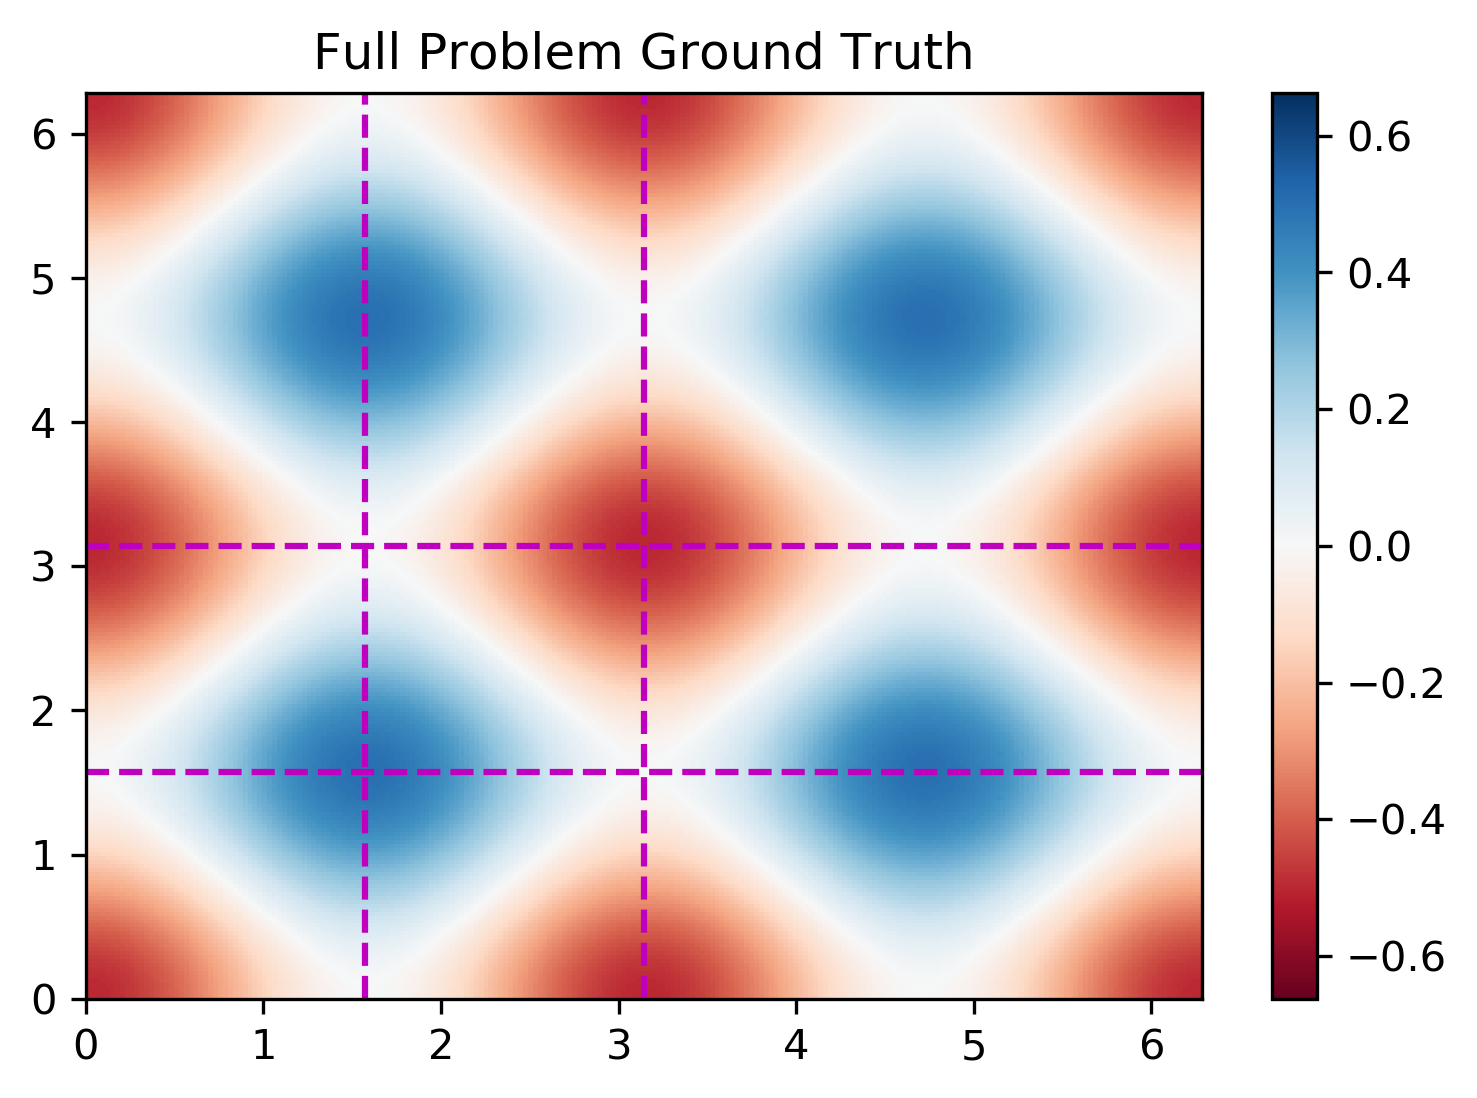

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
z = soln
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
    if index == 0:
        ax.set_title('DBCNN Ground Truth')
    else:
        ax.set_title('DBCNN Ground Truth')
elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:
    ax.set_title('Full Problem Ground Truth')
    x1 = np.max(x)/4
    x2 = 2*np.max(x)/4
    y1 = np.max(y)/4
    y2 = 2*np.max(y)/4
    plt.axvline(x=x1, color = 'm', linestyle = '--')
    plt.axvline(x=x2, color = 'm', linestyle = '--')
    plt.axhline(y=y1, color = 'm', linestyle = '--')
    plt.axhline(y=y2, color = 'm', linestyle = '--')
elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
    ax.set_title('Homogeneous BC Ground truth')

ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

examplename = 'tgv'
identifier = '_' + str(int(soln.shape[0])) + 'x' + str(int(soln.shape[1])) + '_dx' + ('{:.2e}'.format(dx)) + '_'
thisimage = '_groundtruth'


#plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

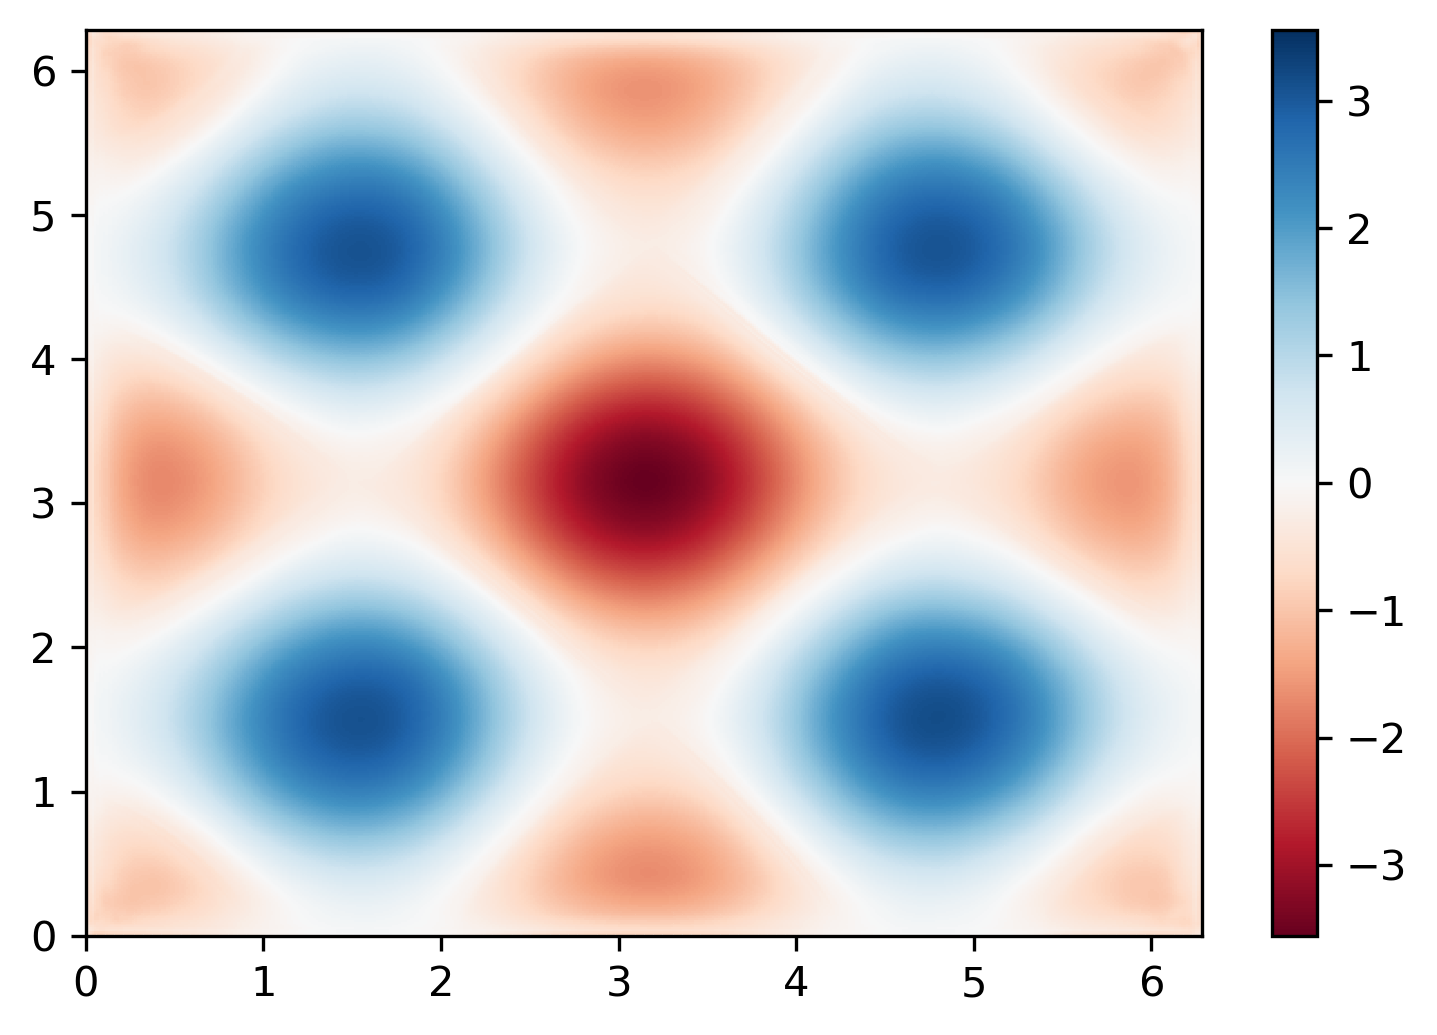

In [21]:
z = pred# - analytical_soln
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
    if index == 0:
        ax.set_title('DBCNN Prediction')
    else:
        ax.set_title('DBCNN Prediction')
elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:
    pass#ax.set_title('Poisson CNN Prediction')
elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
    ax.set_title('HPNN Prediction')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

thisimage = '_pred'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')


plt.show()

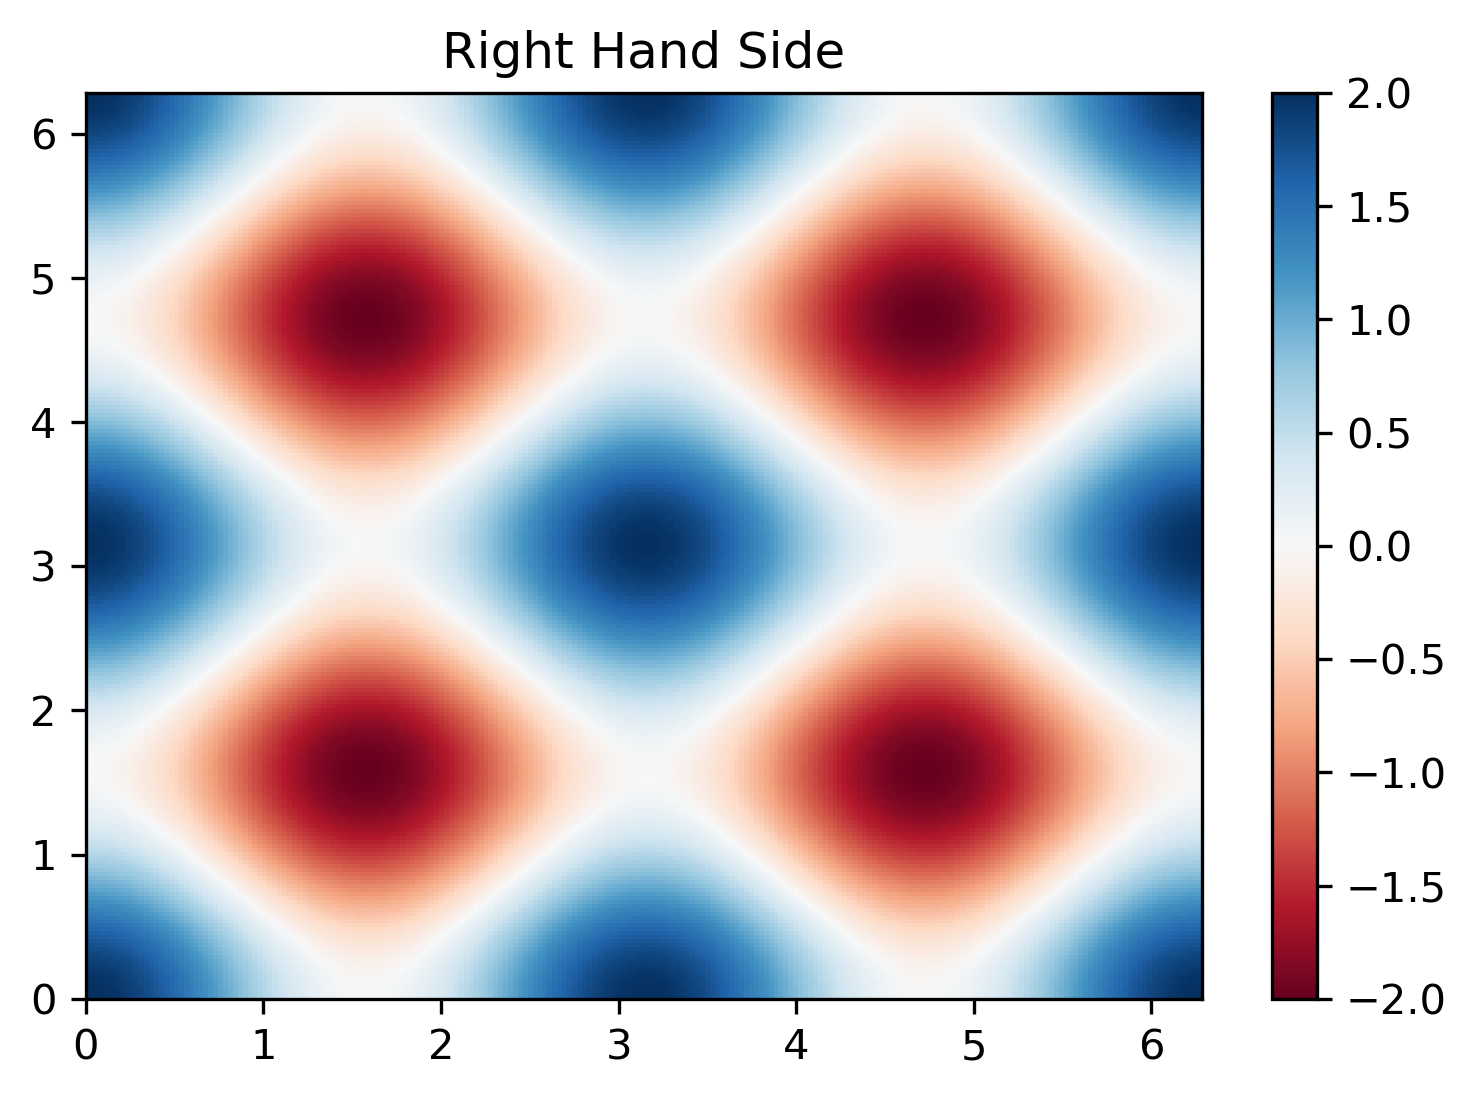

In [8]:
#scaled_rhs, scl = poisson_CNN.dataset.generators.set_max_magnitude_in_batch(rhs, 1.0, return_scaling_factors = True)
#inp = (tf.cast(tf.constant(scaled_rhs), tf.keras.backend.floatx()),tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
#pred = poisson_CNN.dataset.generators.set_max_magnitude_in_batch(-mod(inp), 1/scl)
#pred = -1*mod(inp)

z = rhs[0,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Right Hand Side')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

thisimage = 'rhs'

plt.savefig(img_path + examplename + identifier + thisimage + '.png', bbox_inches = 'tight')

plt.show()

Mean absolute % error: 17.06143952855774
Mean absolute error: 0.025021459238929553


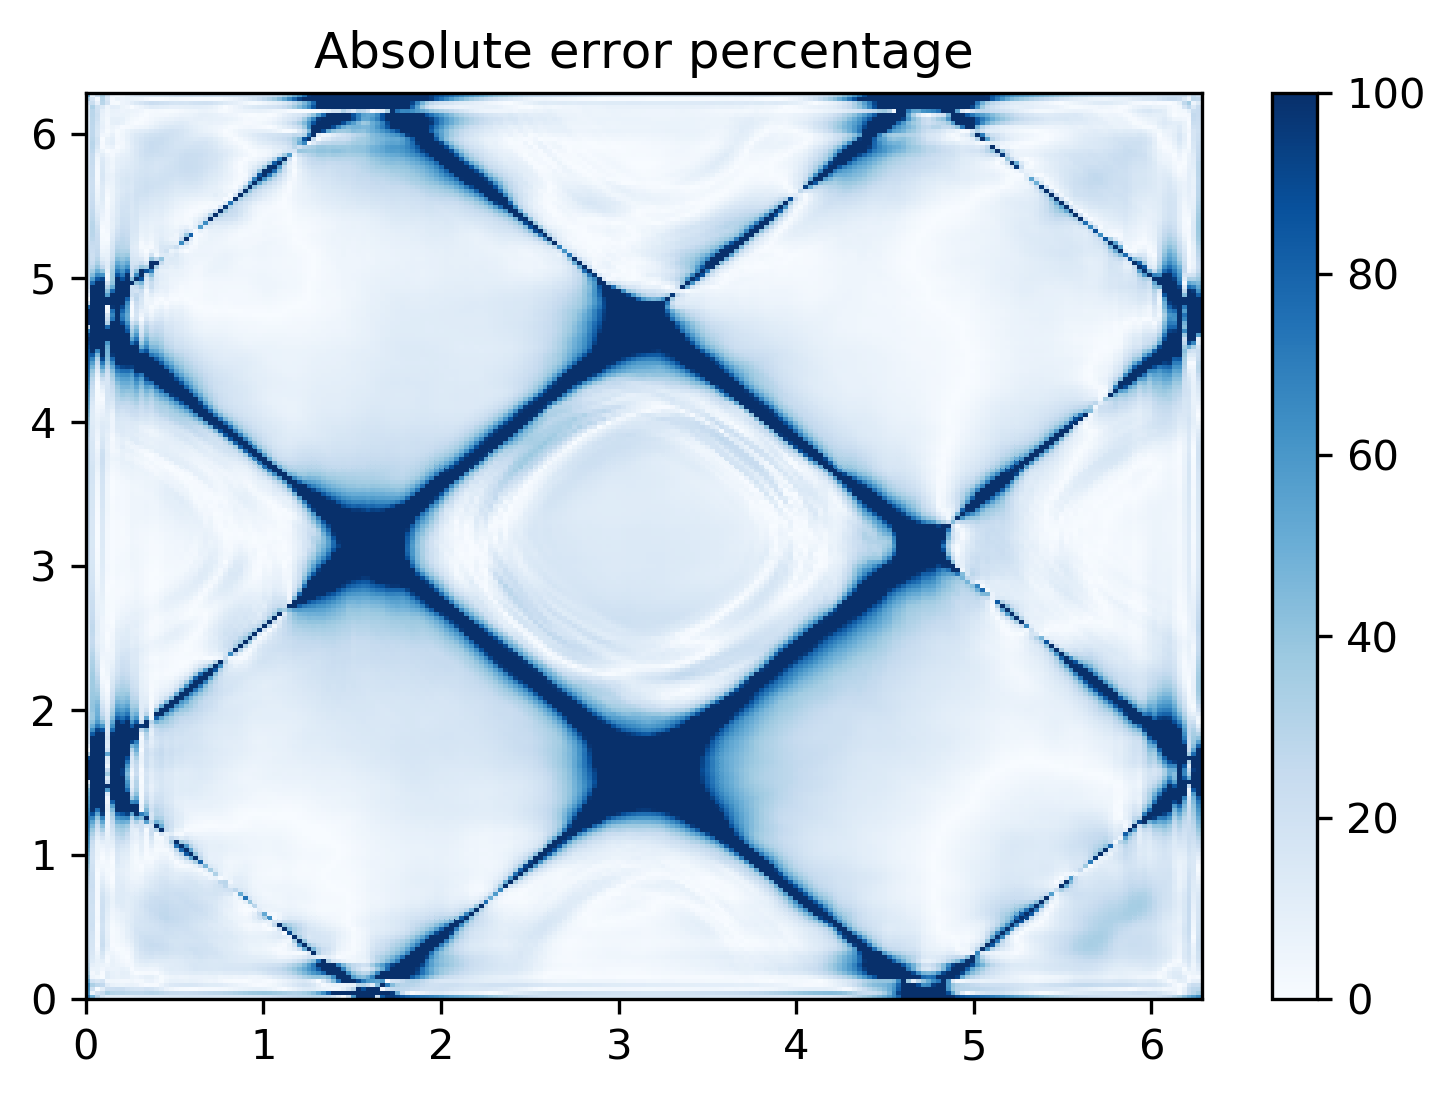

In [9]:
#p_r = np.random.randint(0,soln.shape[0])
#pred = mod(inp)
z = 100*tf.abs((pred - tf.cast(soln, tf.keras.backend.floatx()))/tf.cast(soln, tf.keras.backend.floatx()))
#z = inp[0][p_r,0,...]
#z = tf.abs(pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))/tf.cast(soln[p_r,0,...], tf.keras.backend.floatx())
z_min, z_max = 0,100
print('Mean absolute % error: ' + str(float(np.mean(np.array(z)[np.array(z) < 100]))))
print('Mean absolute error: ' + str(float(tf.reduce_mean(tf.keras.losses.mae(pred, soln)))))
#z_min, z_max = -1,1
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
#c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error percentage')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

thisimage = '_percentageerrormap'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

0.025021459238929556


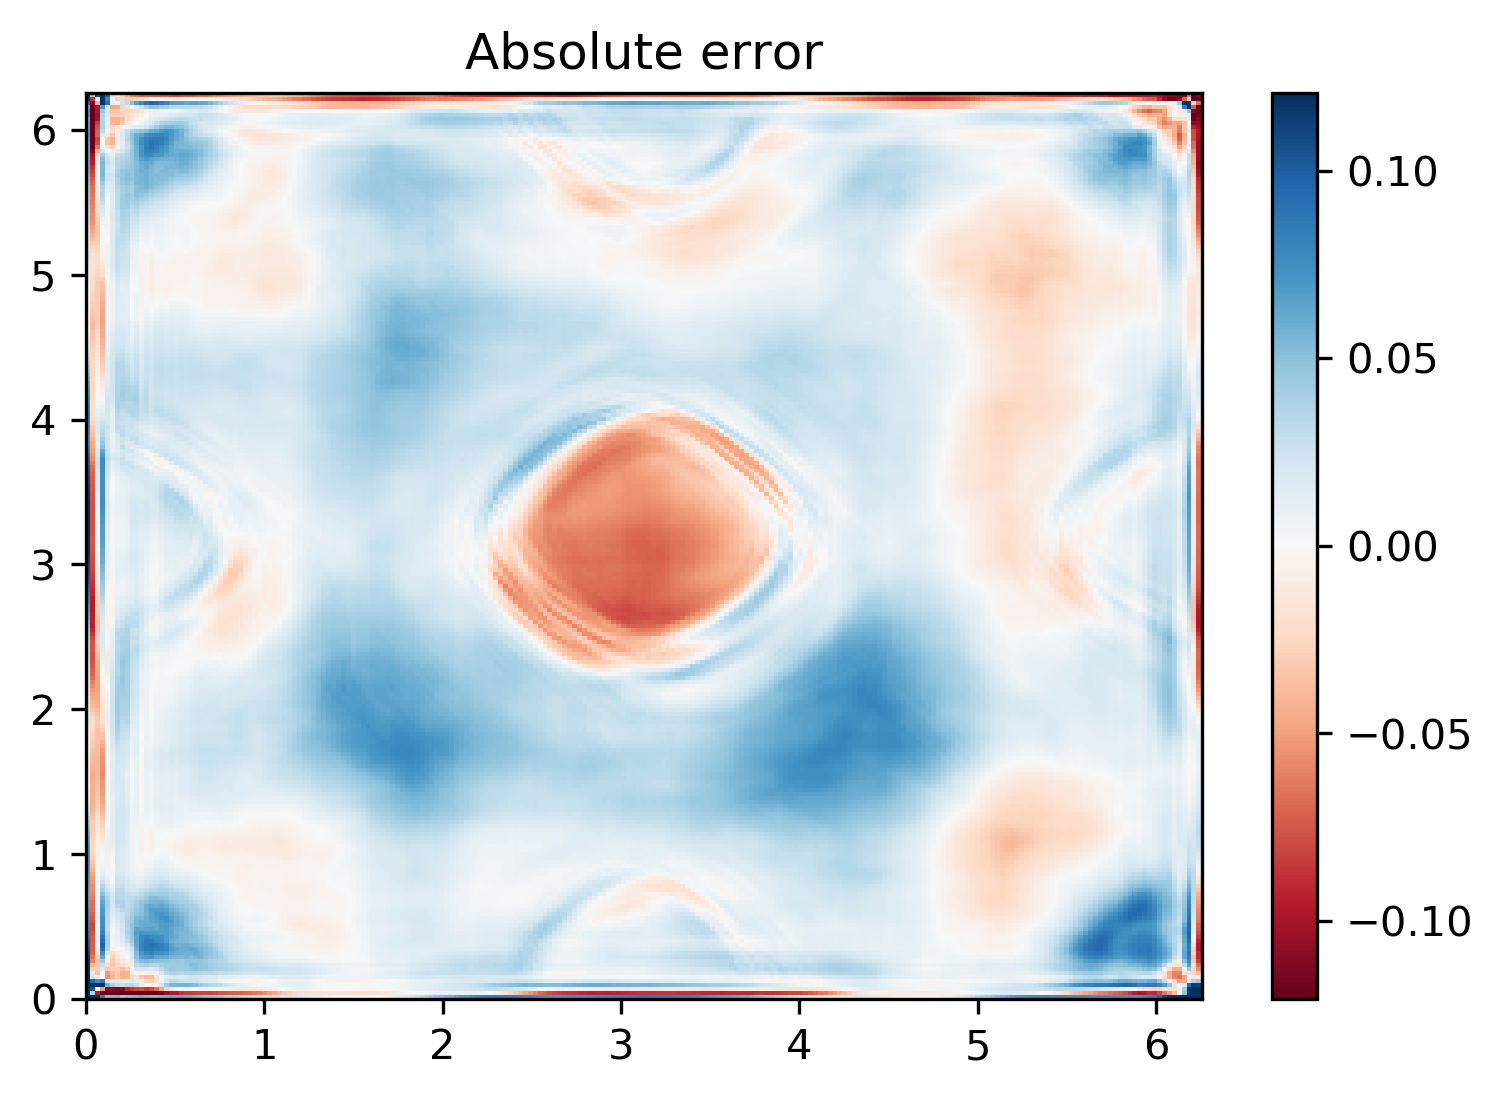

In [11]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][0,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][0,0], soln.shape[-1]), indexing = 'ij')
z = pred - tf.cast(soln, tf.keras.backend.floatx())
z_min, z_max = -0.3*np.abs(z).max(), 0.3*np.abs(z).max()
print(np.mean(np.abs(z)))
#z_min, z_max = -1,1
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
#c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)


thisimage = '_errormap'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(228,)


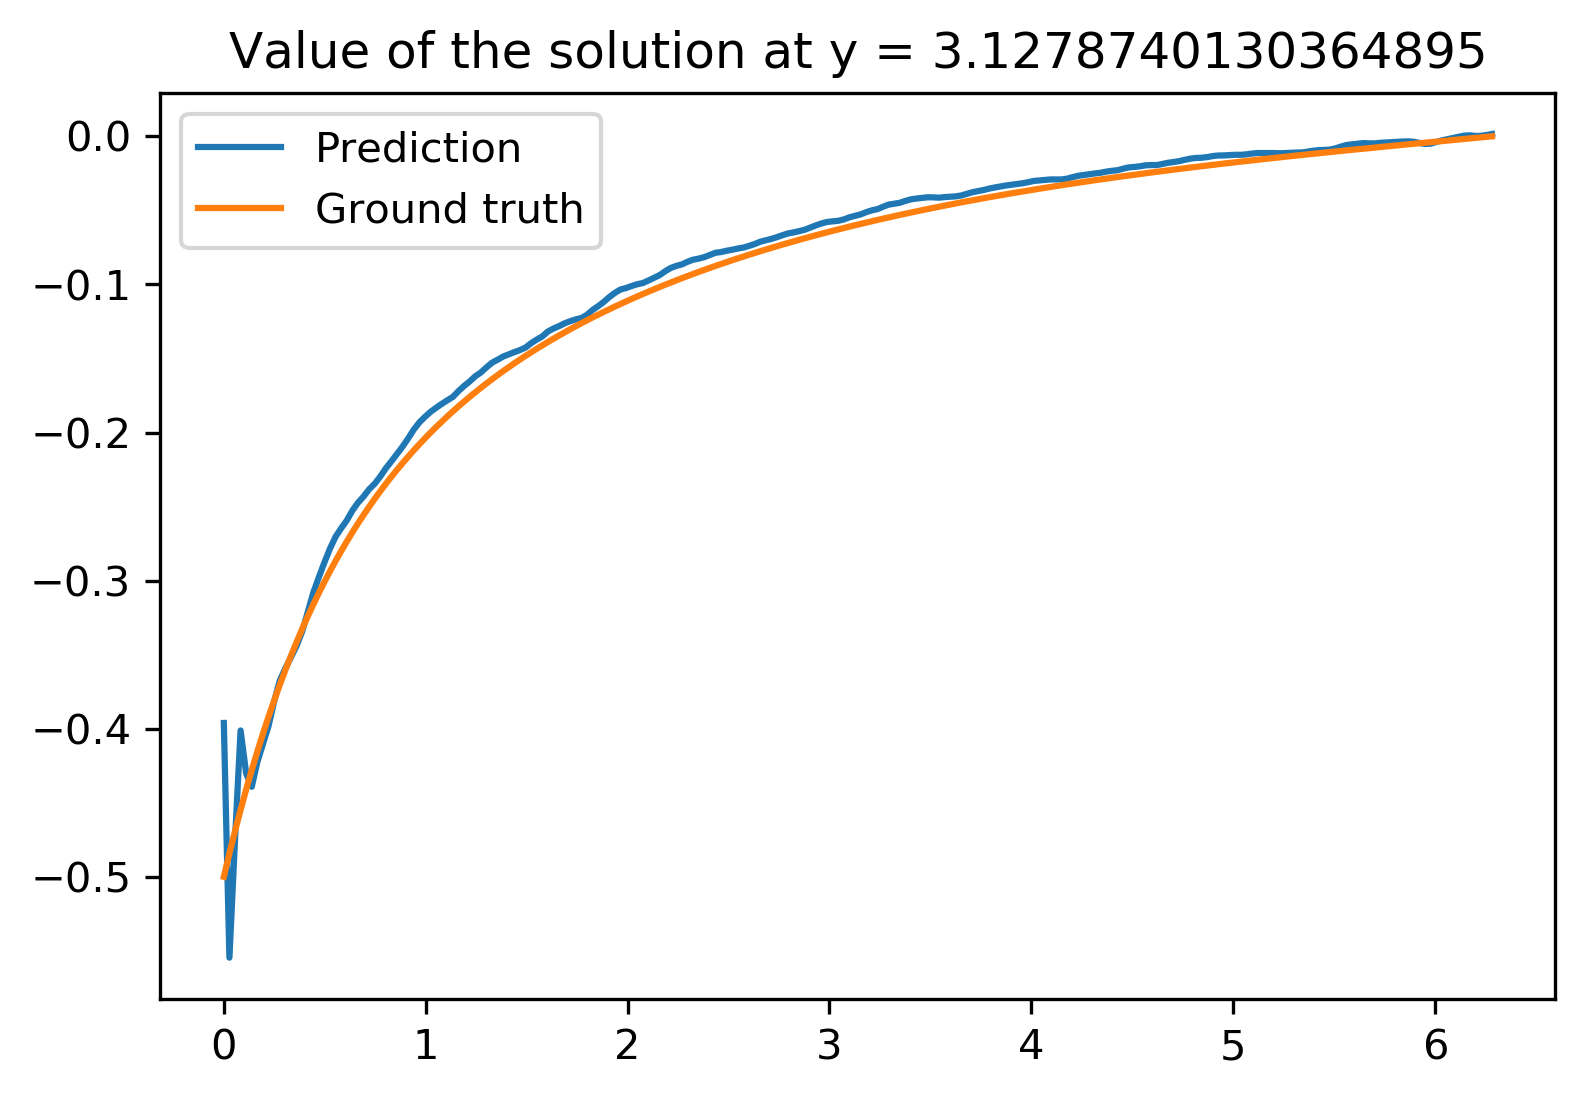

In [9]:
ypos = (soln.shape[-1]//2)
print(np.squeeze(pred[:,ypos]).shape)
#plt.plot(x[:,0], np.squeeze(pred[p_r,0,:,ypos]), label = 'NN')
plt.plot(x[:,0], pred[:,ypos], label = 'Prediction')
plt.plot(x[:,0], soln[:,ypos], label = 'Ground truth')
plt.legend()

plt.title('Value of the solution at y = ' + str((ypos * inp[dxindex][0,0]).numpy()))

thisimage = '_y1'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(228,)


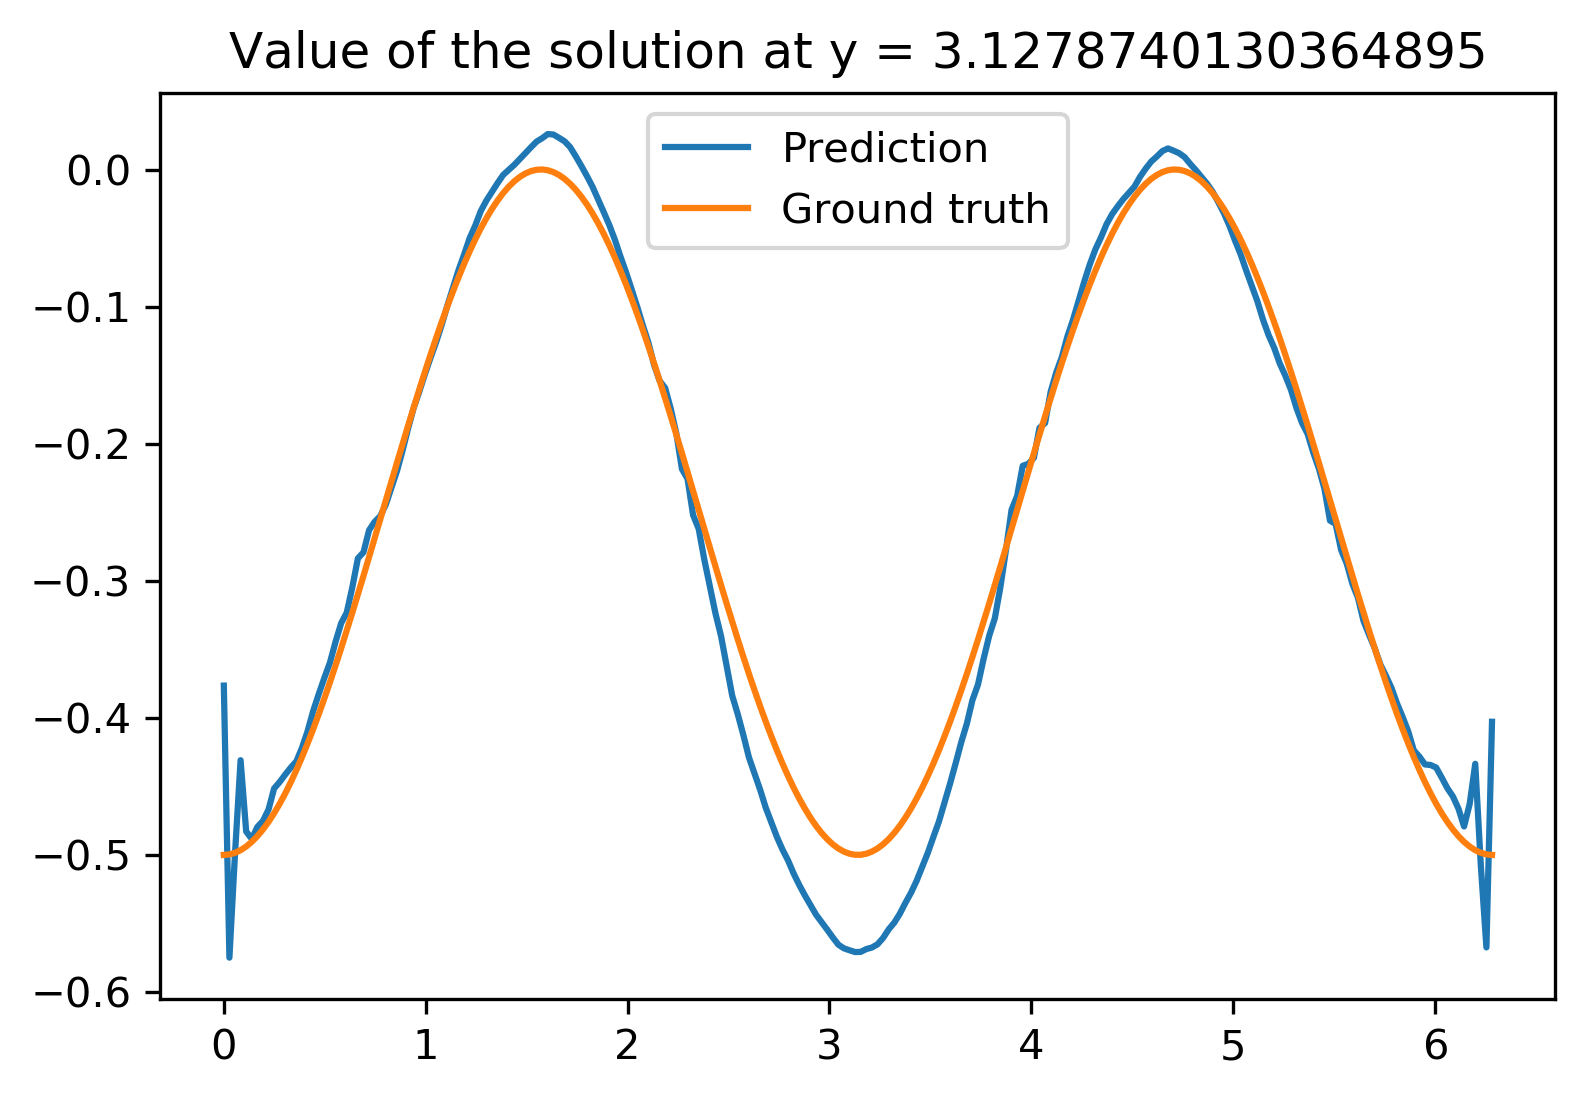

In [21]:
ypos = (2*soln.shape[-1]//4)
print(np.squeeze(pred[:,ypos]).shape)
#plt.plot(x[:,0], np.squeeze(pred[p_r,0,:,ypos]), label = 'NN')
plt.plot(x[:,0], pred[:,ypos], label = 'Prediction')
plt.plot(x[:,0], soln[:,ypos], label = 'Ground truth')
plt.legend()
plt.title('Value of the solution at y = ' + str((ypos * inp[dxindex][0,0]).numpy()))

thisimage = '_y2'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

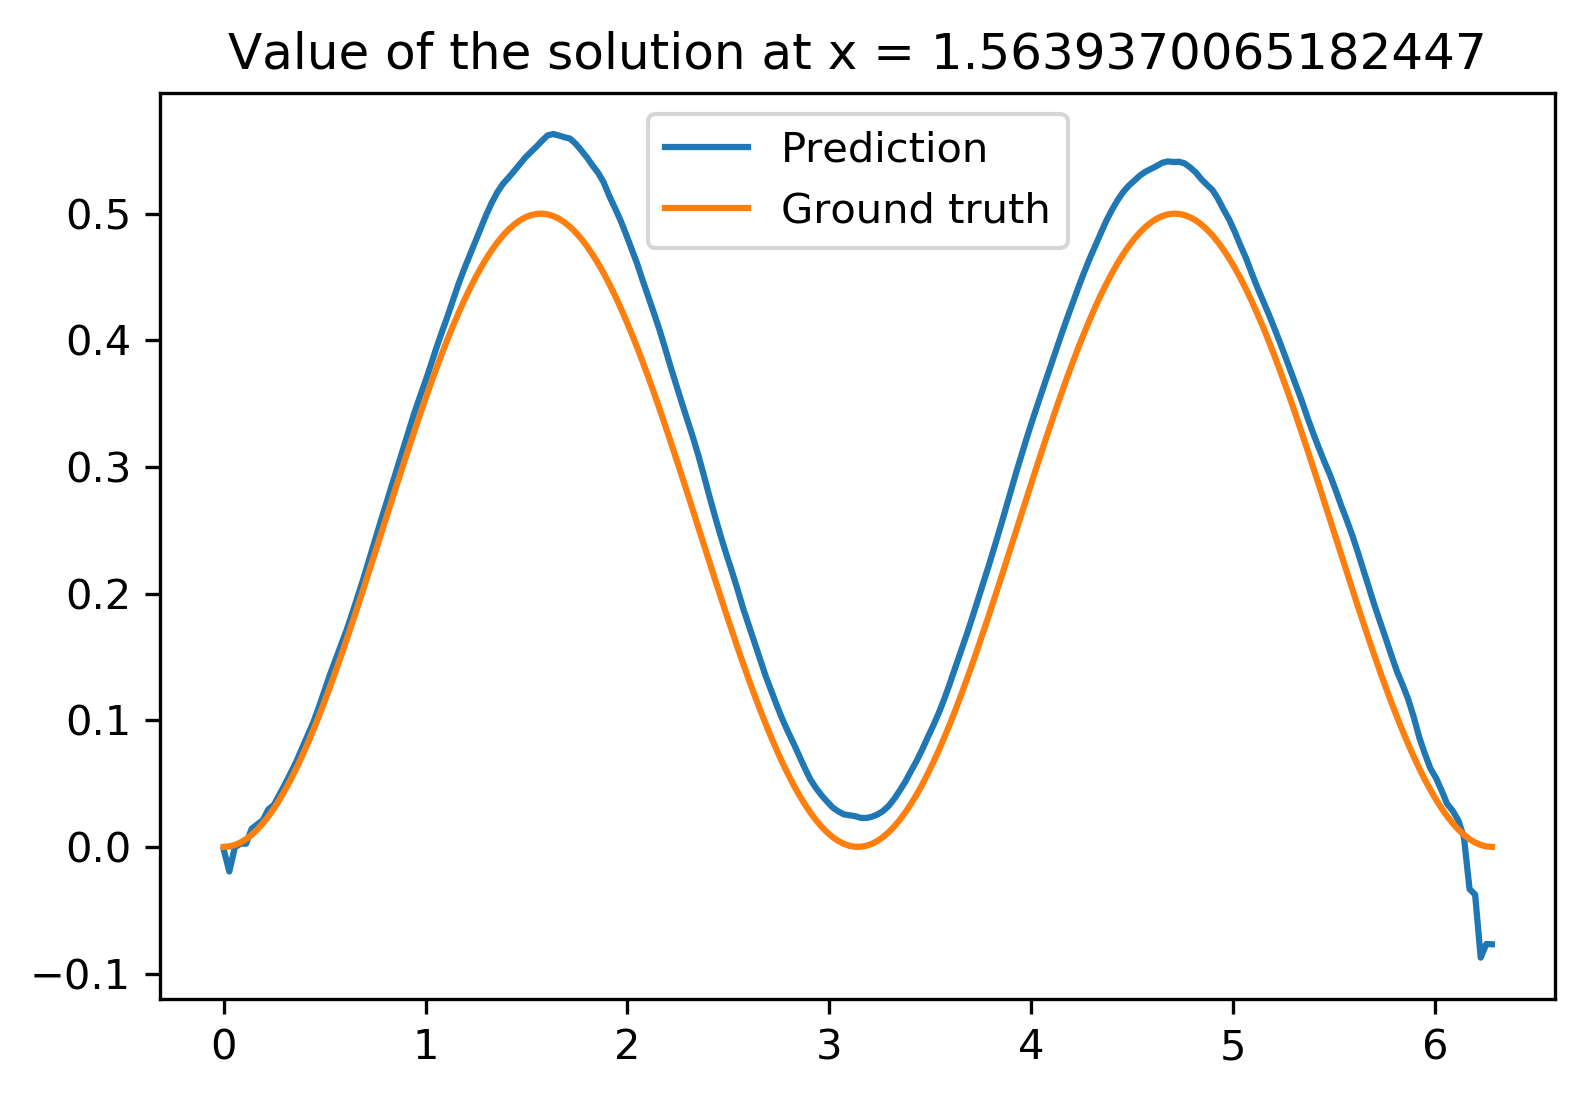

In [22]:
xpos = (soln.shape[-2]//4)
#print(np.squeeze(pred[0,0,:,ypos]).shape)
#plt.plot(x[:,0], np.squeeze(pred[p_r,0,:,ypos]), label = 'NN')
plt.plot(y[0,:], pred[xpos,:], label = 'Prediction')
plt.plot(y[0,:], soln[xpos,:], label = 'Ground truth')
plt.legend()
plt.title('Value of the solution at x = ' + str((xpos * inp[dxindex][0,0]).numpy()))

thisimage = '_x1'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

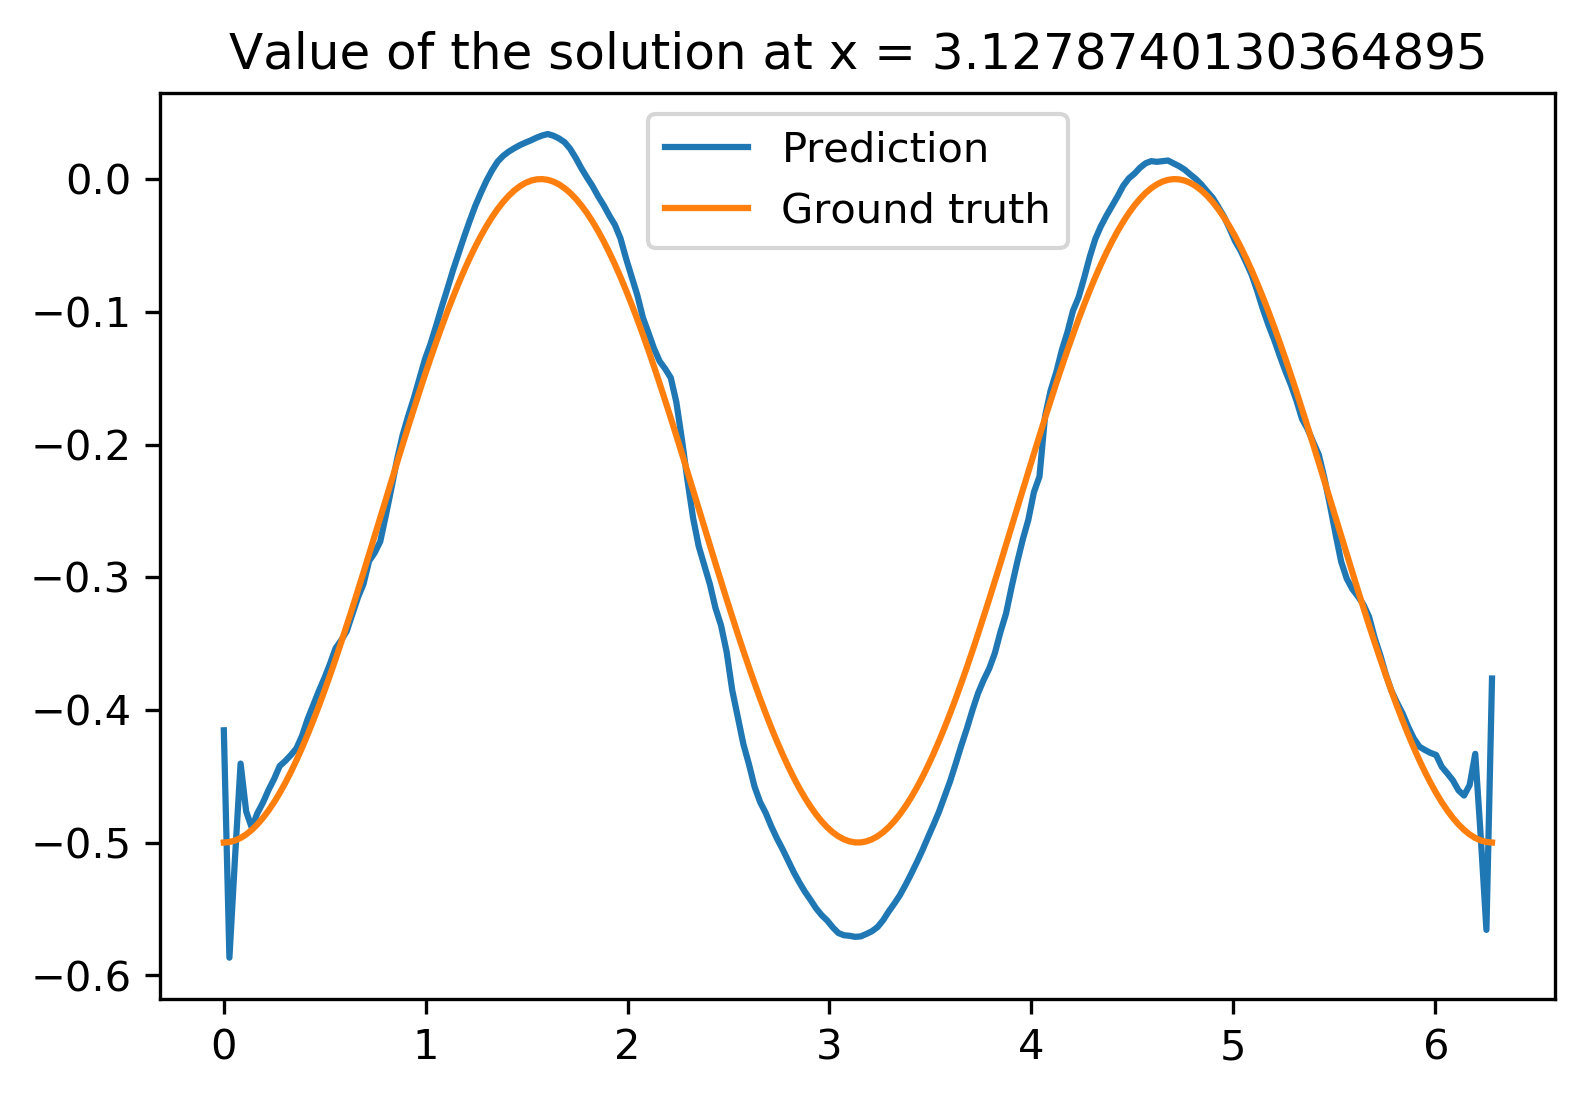

In [23]:
xpos = (2*soln.shape[-2]//4)
#plt.plot(x[:,0], np.squeeze(pred[p_r,0,:,ypos]), label = 'NN')
plt.plot(y[0,:], pred[xpos,:], label = 'Prediction')
plt.plot(y[0,:], soln[xpos,:], label = 'Ground truth')
plt.legend()
plt.title('Value of the solution at x = ' + str((xpos * inp[dxindex][0,0]).numpy()))

thisimage = '_x2'
plt.savefig(img_path + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

Text(0.5, 1.0, 'Imposed boundary conditions')

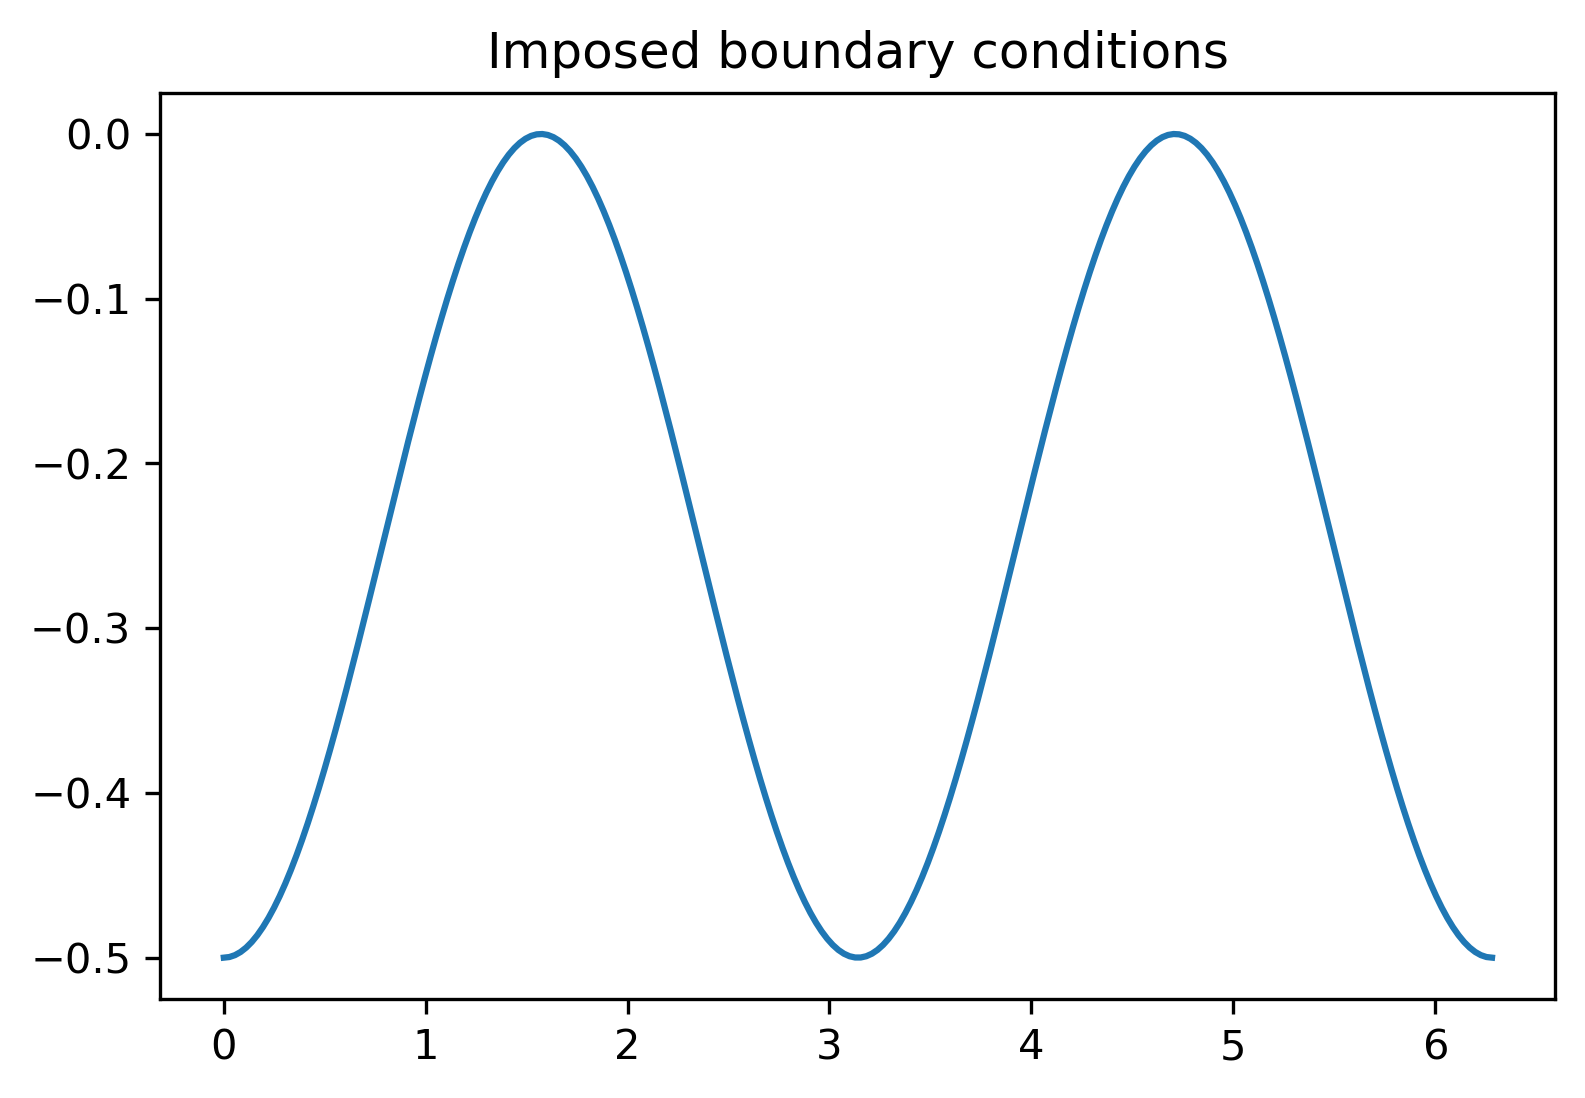

In [25]:
plt.plot(x[:,0], boundaries['left'][0,0], label = 'Top and Right BC')
plt.title('Imposed boundary conditions')

In [11]:
modtimes

[]

In [3]:
#intermediate activations
hpnn = poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet_IA(data_format = 'channels_first', mae_component_weight = 1e+0, mse_component_weight = 1e+1, pooling_block_number=7, n_quadpts = 47, use_deconv_upsample=True, use_batchnorm = False, initial_kernel_size=19, final_kernel_size=3, post_dx_einsum_conv_block_number=9, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4), bias_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4))
hpnn((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())))
hpnn.load_weights('../poisson_CNN/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5')
mod = hpnn
from IPython.display import clear_output
clear_output()
nx = 228
ny = nx#
Lx = 2*np.pi
dx = Lx/(nx+1)
Ly = Lx

a = 1.0
x,y = np.meshgrid(np.linspace(0,Lx,nx),np.linspace(0,Ly,ny), indexing = 'ij')
u = lambda X,Y:-(np.cos(2*X) + np.cos(2*Y))/4
boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':np.zeros((ny))}
rhs = (np.cos(2*x) + np.cos(2*y))
case = 'hpnn'
dxindex = -1
rhs = np.expand_dims(np.expand_dims(rhs, axis = 0), axis = 0)

for key in boundaries.keys():
    boundaries[key] = np.expand_dims(np.expand_dims(boundaries[key], axis = 0), axis = 0)

multigrid_soln = poisson_CNN.solvers.multigrid_poisson_solve(rhs, boundaries, dx, tol = 1e-10)
inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(tf.constant(rhs), tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
pred = mod(inp)
soln = multigrid_soln[0,0,...]

In [ ]:
iapath = img_path + '/intermediate_activations/'
for lyr in range(len(pred)):
    print('Layer no ' + str(lyr))
    for ch in range(int(pred[lyr].shape[1])):
# lyr = 0
# ch = 8
        filename = 'tgv_ia_layer' + str(lyr) + '_channel' + str(ch) + '.png'
        z = pred[lyr][0,ch,...]# - analytical_soln
        fig, ax = plt.subplots()
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('HPNN Prediction')
        ax.axis([x.min(), x.max(), y.min(), y.max()])
        fig.colorbar(c, ax=ax)
        plt.savefig(iapath + filename, bbox_inches = 'tight')
        plt.show()


In [ ]:
#timing
nx = 3000
ny = nx#
Lx = 2*np.pi
dx = Lx/(nx+1)
Ly = Lx

a = 1.0
x,y = np.meshgrid(np.linspace(0,Lx,nx),np.linspace(0,Ly,ny), indexing = 'ij')
u = lambda X,Y:-(np.cos(2*X) + np.cos(2*Y))/4

if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
    index = 0#-1
    boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':u(x[index,:], y[index,:])}
    rhs = np.zeros(x.shape)
    case = 'dbcnn'# + (lambda: 'leftbottom' if index == 0 else 'righttop')()
    dxindex = 1
elif type(mod) == poisson_CNN.models.Poisson_CNN:#pcnn:#
    boundaries = {'top': u(x[:,-1], y[:,-1]), 'bottom':u(x[:,0], y[:,0]), 'right': u(x[-1,:], y[-1,:]), 'left': u(x[0,:], y[0,:])}
    soln = u(x,y)
    rhs = (np.cos(2*x) + np.cos(2*y))
    case = 'pcnn'
    dxindex = -1
elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
    boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':np.zeros((ny))}
    rhs = (np.cos(2*x) + np.cos(2*y))
    case = 'hpnn'
    dxindex = -1
rhs = np.expand_dims(np.expand_dims(rhs, axis = 0), axis = 0)

for key in boundaries.keys():
    boundaries[key] = np.expand_dims(np.expand_dims(boundaries[key], axis = 0), axis = 0)

import time
mgridtimes = []
modtimes = []
for k in range(20):
    t0 = time.time()
    #multigrid_soln = poisson_CNN.solvers.multigrid_poisson_solve(rhs, boundaries, dx, tol = 1e-10)
    tmult = float(time.time() - t0)
    mgridtimes.append(tmult)

    if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
        #inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(boundaries['left'], tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()), tf.stack([nx]))
        inp = (tf.cast(tf.concat(list(boundaries.values()), axis = 0), tf.keras.backend.floatx()), tf.cast(tf.constant([[dx],[dx],[dx],[dx]]), tf.keras.backend.floatx()), tf.stack([nx,nx,nx,nx]))
        t1 = time.time()
        #pred = np.array(mod(inp) * tf.reduce_max(tf.abs(boundaries['left'])))[0,0,...]
        pred = mod(inp)
        tmod = time.time() - t1
        soln = multigrid_soln[0,0,...]
    elif type(mod) == poisson_CNN.models.Poisson_CNN:#pcnn:#
        inp = (tf.cast(tf.constant(rhs), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['left']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['top']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['right']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['bottom']), tf.keras.backend.floatx()),tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
        t1 = time.time()
        pred = np.array(mod(inp))[0,0,...]
        tmod = time.time() - t1
    elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
        inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(tf.constant(rhs), tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
        t1 = time.time()
        #pred = np.array(mod(inp) * tf.reduce_max(tf.abs(rhs)))[0,0,...]
        pred = mod(inp)
        tmod = time.time() - t1
        #soln = multigrid_soln[0,0,...]
    modtimes.append(tmod)

print('Multigrid time (s): ' + str(np.mean(mgridtimes)))
print('Model time (s): ' + str(np.mean(modtimes)))
    
z_min, z_max = np.min([-np.abs(pred).max(), -np.abs(multigrid_soln).max()]), np.max([np.abs(pred).max(), np.abs(multigrid_soln).max()])

In [35]:
dxes = []
rmses = []
linreg_dxes = []
linreg_rmses = []
for k in list(range(110,400,5)) + [500, 192, 228]:
    nx = k
    ny = nx#
    Lx = 2*np.pi
    dx = Lx/(nx+1)
    Ly = Lx

    a = 1.0
    x,y = np.meshgrid(np.linspace(0,Lx,nx),np.linspace(0,Ly,ny), indexing = 'ij')
    u = lambda X,Y:-(np.cos(2*X) + np.cos(2*Y))/4

    if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
        index = 0#-1
        boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':u(x[index,:], y[index,:])}
        rhs = np.zeros(x.shape)
        case = 'dbcnn'# + (lambda: 'leftbottom' if index == 0 else 'righttop')()
        dxindex = 1
    elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:#
        boundaries = {'top': u(x[:,-1], y[:,-1]), 'bottom':u(x[:,0], y[:,0]), 'right': u(x[-1,:], y[-1,:]), 'left': u(x[0,:], y[0,:])}
        soln = u(x,y)
        rhs = (np.cos(2*x) + np.cos(2*y))
        case = 'pcnn'
        dxindex = -1
    elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
        boundaries = {'top':np.zeros((nx)), 'bottom':np.zeros((nx)), 'right':np.zeros((ny)), 'left':np.zeros((ny))}
        rhs = (np.cos(2*x) + np.cos(2*y))
        case = 'hpnn'
        dxindex = -1
    rhs = np.expand_dims(np.expand_dims(rhs, axis = 0), axis = 0)

    for key in boundaries.keys():
        boundaries[key] = np.expand_dims(np.expand_dims(boundaries[key], axis = 0), axis = 0)

    import time

    t0 = time.time()
    multigrid_soln = poisson_CNN.solvers.multigrid_poisson_solve(rhs, boundaries, dx, tol = 1e-10)
    tmult = float(time.time() - t0)

    if type(mod) == poisson_CNN.models.Dirichlet_BC_NN:
        inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(boundaries['left'], tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()), tf.stack([nx]))
        t1 = time.time()
        pred = np.array(mod(inp) * tf.reduce_max(tf.abs(boundaries['left'])))[0,0,...]
        tmod = time.time() - t1
        soln = multigrid_soln[0,0,...]
    elif type(mod) == pcnn:#poisson_CNN.models.Poisson_CNN:#
        inp = (tf.cast(tf.constant(rhs), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['left']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['top']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['right']), tf.keras.backend.floatx()),tf.cast(tf.constant(boundaries['bottom']), tf.keras.backend.floatx()),tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
        t1 = time.time()
        pred = np.array(mod(inp))[0,0,...]
        tmod = time.time() - t1
    elif type(mod) == poisson_CNN_old.models.Homogeneous_Poisson_NN_Fluidnet:
        inp = (poisson_CNN.set_max_magnitude_in_batch(tf.cast(tf.constant(rhs), tf.keras.backend.floatx()), 1.0), tf.cast(tf.constant([[dx]]), tf.keras.backend.floatx()))
        t1 = time.time()
        pred = np.array(mod(inp) * tf.reduce_max(tf.abs(rhs)))[0,0,...]
        tmod = time.time() - t1
        soln = multigrid_soln[0,0,...]

    q = np.abs(pred - tf.cast(soln, tf.keras.backend.floatx()))/np.abs(tf.cast(soln, tf.keras.backend.floatx()))
    rms = tf.sqrt(tf.reduce_mean((pred - tf.cast(soln, tf.keras.backend.floatx()))**2))
    mae = tf.reduce_mean(tf.abs(pred - tf.cast(soln, tf.keras.backend.floatx())))
    dxes.append(dx)
    rmses.append(rms)
    if (k > 192) and (k <= 228):
        linreg_dxes.append(dx)
        linreg_rmses.append(rms)

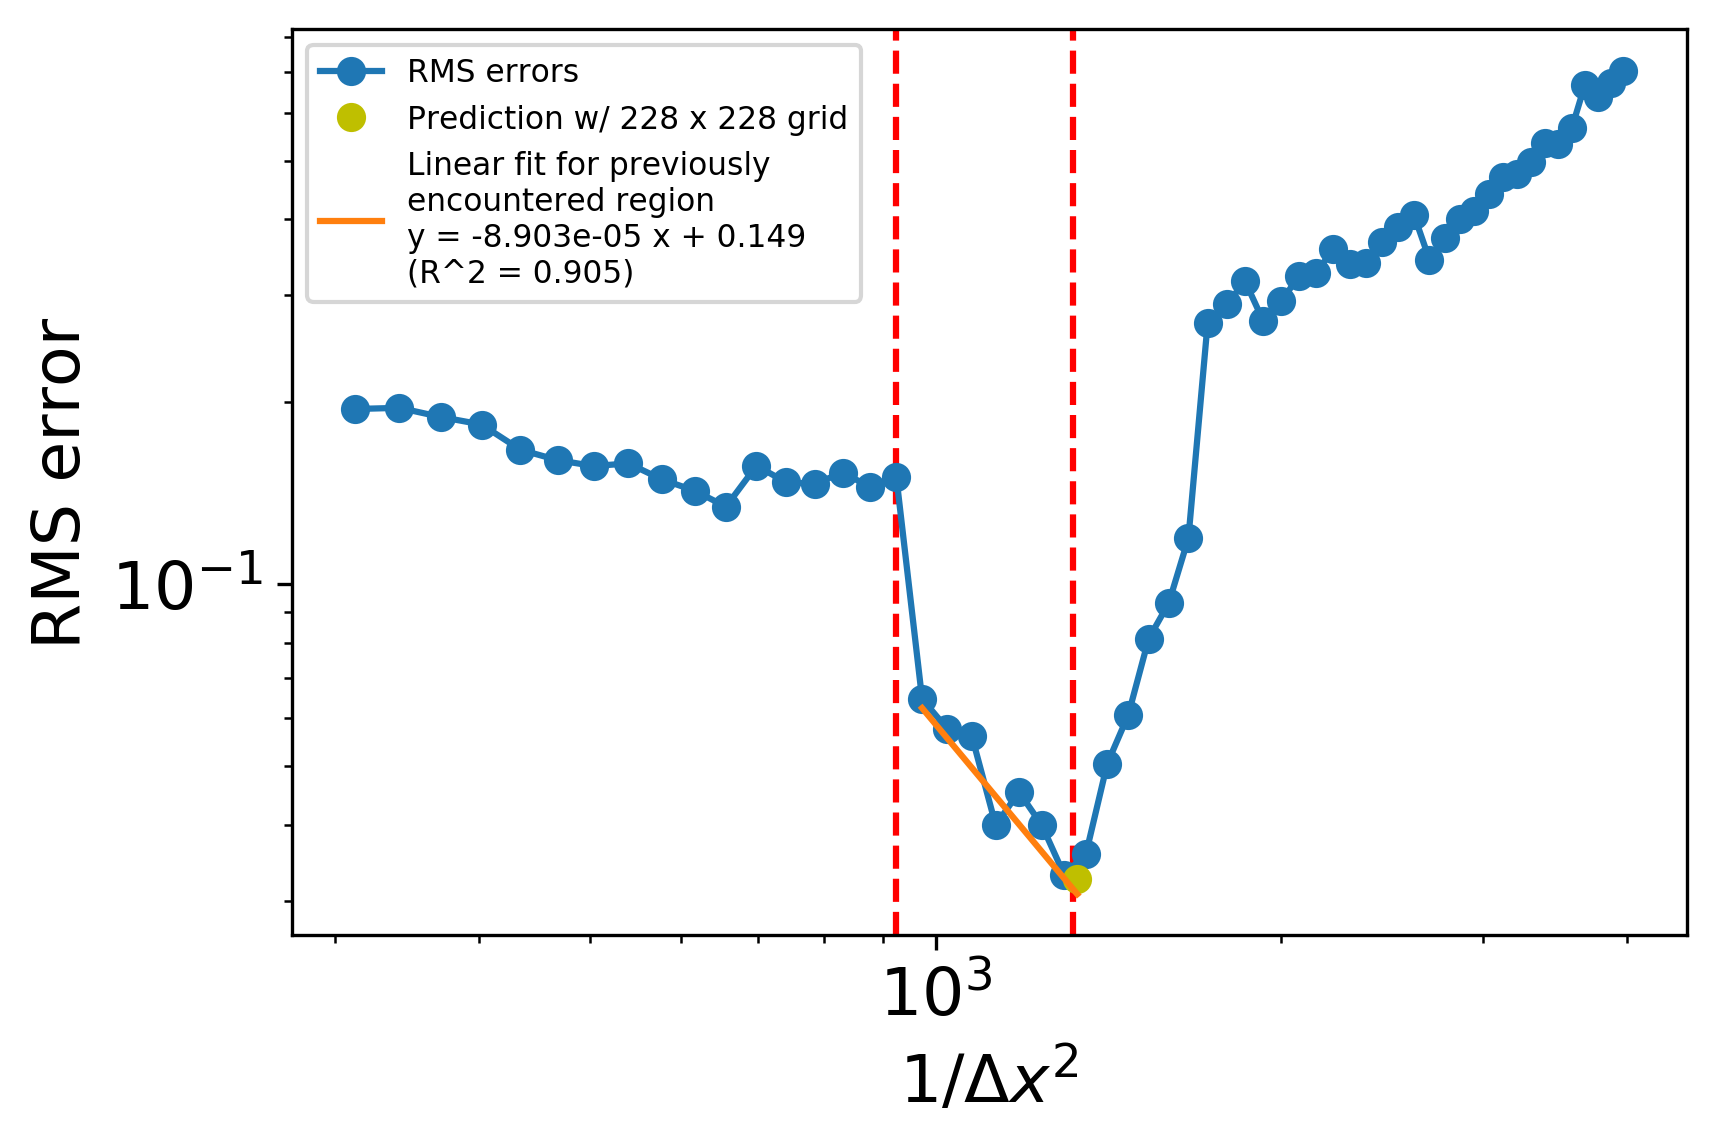

In [81]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(1/np.expand_dims(linreg_dxes, axis = 1)**2,np.expand_dims(linreg_rmses, axis = 1))
lr_pred = [(lr.predict(1/(np.reshape(linreg_dxes[0], (1,-1))**2))).flatten(), (lr.predict(1/(np.reshape(linreg_dxes[-1], (1,-1))**2))).flatten()]

import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
plt.rc('text', usetex = False)
fig = plt.figure()
plt.rcParams.update({'font.size':16})
ax1 = plt.axes()
ax1.axvline(x = 1/(2*np.pi/(191))**2, color = 'r', linestyle = '--')
ax1.axvline(x = 1/(2*np.pi/(228))**2, color = 'r', linestyle = '--')
plt.xlabel('$1/ \Delta x ^2$')
plt.ylabel('RMS error')
plt.loglog(1/np.array(dxes[:-3])**2, rmses[:-3], marker = 'o', label = 'RMS errors')
plt.loglog(1/dxes[-1]**2, rmses[-1], marker = 'o', color='y', linestyle = '', label = 'Prediction w/ 228 x 228 grid')
plt.loglog(1/np.array([linreg_dxes[0], linreg_dxes[-1]])**2, lr_pred, label = 'Linear fit for previously\nencountered region\ny = ' + '{:.3e}'.format(lr.coef_[0,0]) + ' x + ' + '{:.3f}'.format(lr.intercept_[0]) + '\n(R^2 = ' + '{:.3f}'.format(lr.score(1/np.expand_dims(linreg_dxes, axis = 1)**2, np.expand_dims(linreg_rmses, axis = 1))) + ')')
plt.legend(prop = {'size' : 7.5})

plt.savefig(img_path + 'tgv_rms_error_by_gridsize.pdf', bbox_inches = 'tight')

In [56]:
lr.intercept_

array([0.14899993])

In [55]:
lr.score(1/np.expand_dims(linreg_dxes, axis = 1)**2, np.expand_dims(linreg_rmses, axis = 1))

0.9050829124393086